In [199]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib, collections
from scipy.stats import norm
import imp, os, pickle
import warnings
import sys
from matplotlib import collections  as mc
from scipy.stats import poisson
warnings.filterwarnings("ignore")
from scipy.stats import norm
sns.set(style="white")
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

## Parameters

In [200]:
f = 0.1 #Mining rate
m = 200 #Number of voting chains
log_epsilon = 20 #Confirmation guarantee

'''
Number of public proposal block
proposer_block[0] is mined by honest node, proposer_block[1] is mined by adversarial node
proposer_block[0] is A in the report, proposer_block[1] is B in the report
'''
proposer_blocks = 2 

beta_actual = 0.2 # probability with which an incoming voting block has been mined by adversary

'''
probability of choosing proposal_block[0] and proposal_block[1], respectively, by honest nodes.
'''
prob_selecting_proposer_blocks_by_honest_nodes = [0.75, 0.25] 


beta_calc = np.array([0.1, 0.15, 0.2, 0.25, .3, .35, 0.4]) # probability using which V_estimate is calculated

## Prism Latency Simulation

In [202]:
# Number of adverserial blocks in private at time t
'''
def adverserial(t, beta, fv):
    x = np.arange(0,1000,1)
    mu = fv*t*beta/(1-beta)
    return poisson.pmf(x, mu)
'''


#Probability that a vote for with depth k will be removed when adversary has Z_t blocks in the 
'''
def p_k_t(k, Z_t,beta):
    ans = 0
    k = int(k)
    # print(k)
    for i in range(k):
        ans += Z_t[i]*np.power(beta/(1-beta), k - i)
    ans += np.sum(Z_t[k:])
    return ans
'''
def p_k_t(k, Z_t, beta):
    ans = np.power(beta/(1-beta), k - Z_t)
    return ans


def runExp(m, log_epsilon, fv, proposer_blocks, prob_selecting_proposer_blocks_by_honest_nodes, beta_calc, beta_actual):
    events = int(20000*log_epsilon)
    time_array = np.zeros_like(beta_calc)
    fv_effective = fv/(1.0+2*fv) #Forking
    exp_random_v = np.random.exponential(1/(m*fv_effective), size=events)
    chain_random_v = np.random.randint(m, size=events)
    
    

    
    for j, beta in enumerate(beta_calc):
#         exponent = 0.8*(1-2*beta)/(1-beta)*np.log((1-beta)/beta)

        print('beta')
        print(beta)
        
        # the following variables are used for the computation of \underbar{V}_{n}(r)
        votes_permanence_E, votes_permanence_V =  np.zeros(m),  np.zeros(m)
        time, mean, var  = 0,0,0
        
        
        
            
        '''
        The following vector contains proposal block voted by each of the voter chain
        It can be updated everytime a voter block is mined 
        (specifically, in case of tie in length of competing forked chains)
        Initially, no voter block has been mined and so no voting yet, thus, initializing with None
        '''
        proposal_block_selected_by_voter_chain = np.asarray([None]*m) 


        '''
        n_honest is the number of votes for proposal_block[0] in a chain along the voting tree
        n_adversary is the number of votes for proposal_block[1] in a chain along the voting tree
        Initially, no votes cast, so, initialized with 0
        '''
        n_honest = np.zeros(m)
        n_adversary = np.zeros(m)
        
        
        
        
        
        for i, tDiff in enumerate(exp_random_v):
            # print(i)
            # incrementing time
            time += tDiff
            
            
            # Selecting the chain to add the voting block (by sortition)
            rChain = chain_random_v[i]
            
            
            '''
            Determining whether the mined block at each event is from an honest node or from an adversary
            Note that the first vote in any voter tree is cast by honest node
            '''
            if (n_adversary[rChain] == 0) and (n_honest[rChain] == 0):
                mined_by_adversary_or_honest_node = 'Honest'
            else:    
                mined_by_adversary_or_honest_node = np.random.choice(['Honest', 'Adversary'], 1, p = [1 - beta_actual, beta_actual])
         


            
            
            '''
            (1) Determining whether adversary mined the block or honest node mined the block
            (2) Determining where the vote gets added among the two competing forked voter chains
            '''
            if mined_by_adversary_or_honest_node == 'Adversary':                    
                # block mined by adversary always votes for adversarial proposer block
                # this vote is never flipped
                proposal_block_selected_by_voter_chain[rChain] = 1
                
                # If mined by adversary, the vote has to go to the adversarial proposer block
                n_adversary[rChain] += 1
                
            else:
                # If mined by honest node, then we have following cases
                if n_honest[rChain] > n_adversary[rChain]:
                    # Applying longest chain protocol
                    n_honest[rChain] += 1
                elif n_honest[rChain] < n_adversary[rChain]:
                    # print('wrong2')
                    # Applying longest chain protocol
                    n_adversary[rChain] += 1
                else:
                    '''
                    The case for n_honest[rChain] = n_adversary[rChain]
                    
                    (1) In case of the first vote in the voting chain (that is no vote has been cast) by an 
                    honest node, the proposal block that gets heard first by the honest node is given the vote. 
                    This is captured in probabilistic sense. 
                    
                    (2) In subsequent ties, the vote of the voting tree is flipped and goes to adversarial proposer block
                    '''
                    if n_honest[rChain] == 0:
                        '''
                        The first vote in the voter tree.
                        This also implies n_adversary[rChain] = 0.
                        '''
                        proposal_block_selected_by_voter_chain[rChain] = np.random.choice([0, 1], 1, p = prob_selecting_proposer_blocks_by_honest_nodes)
                        
                    
                        if proposal_block_selected_by_voter_chain[rChain] == 0:
                            n_honest[rChain] += 1

                        else:
                            n_adversary[rChain] += 1
                            
                            
                            
                    else:
                        # subsequent ties
                        n_adversary[rChain] += 1
                        n_honest[rChain] = 0 # the length of the voting chain for honest proposal block is set to 0
                        proposal_block_selected_by_voter_chain[rChain] = 1 # giving vote to adversarial proposer block
                        
            
            
            
            

            # Solidified probability
            # The votes that can flip are those that are given to proposer block mined by honest node
            if proposal_block_selected_by_voter_chain[rChain] == 0:
                # the length of the forked adversarial voter chain is given by n_adversary[rChain]
                p_i = 1 - p_k_t(n_honest[rChain], n_adversary[rChain], beta)
                
                # Z_t = adverserial(time, beta, fv)
                # p_i = 1 - p_k_t(n_honest[rChain], Z_t, beta)
                
                # Updating the mean and variance
                mean -= votes_permanence_E[rChain]
                var  -= votes_permanence_V[rChain]
                
                '''
                The following code snippet calculates the mean and variance of number of votes cast to the
                proposal_block[0] by the voter tree rChain. Note that each voter tree can cast at max 1 vote.
                ''' 
                votes_permanence_E[rChain] = p_i  
                votes_permanence_V[rChain] = p_i*(1-p_i)
                
                # Updating the total number of votes for proposal_block[0] from all the voter trees
                mean += votes_permanence_E[rChain]
                var  += votes_permanence_V[rChain]
                
  

                '''
                There are two conditions for confirmation of either of double spent transaction -

                (1) proposal_block[0] is confirmed 
                (2) proposal_block[1] is confirmed
                '''
 #               print('mean')
 #               print(mean)
                
                # proposal_block[0] is confirmed
                if mean-np.sqrt(2*var*log_epsilon) >= m/2+1:
                    time_array[j] = time
                    print('Honest proposer block confirmed')
                    break


            
            
            
            # counting number of voter chains that haven't cast vote for any proposal block
            U = np.count_nonzero(proposal_block_selected_by_voter_chain == None)
            
            # counting number of voter chains that currently casts vote for proposal_block[0]
            V_current = np.count_nonzero(proposal_block_selected_by_voter_chain == 0)
            
            '''
            counting number of voter chains that have cast vote for adversarial proposer block, proposal_block[1]
            Once a voter tree has cast vote for adversarial proposer block, the vote is permanent
            '''
            permanent_votes_for_adversarial_proposal_block = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)
#            print('permanent_votes_for_adversarial_proposal_block')
#            print(permanent_votes_for_adversarial_proposal_block)
                            
            # proposal_block[1] is confirmed
            if V_current + U < permanent_votes_for_adversarial_proposal_block:
                print('Adversarial proposer block confirmed')
                time_array[j] = time               
                break
            
            
    return time_array


prism_ans = np.zeros_like(beta_calc)
#T1: Time taken for a unique proposer block to refer the tx_block
prism_ans += np.power(np.e, 1*f)/f

#T2: Time taken for a proposer block to get confirmed
no_exp = 5
for i in range(no_exp):
    prism_ans += runExp(m, log_epsilon, f, proposer_blocks, prob_selecting_proposer_blocks_by_honest_nodes, beta_calc, beta_actual)
prism_ans /= no_exp

beta
0.1
Honest proposer block confirmed
beta
0.15
Honest proposer block confirmed
beta
0.2
Honest proposer block confirmed
beta
0.25
Adversarial proposer block confirmed
beta
0.3
Adversarial proposer block confirmed
beta
0.35
Adversarial proposer block confirmed
beta
0.4
Adversarial proposer block confirmed
beta
0.1
Honest proposer block confirmed
beta
0.15
Honest proposer block confirmed
beta
0.2
Honest proposer block confirmed
beta
0.25
Honest proposer block confirmed
beta
0.3
Adversarial proposer block confirmed
beta
0.35
Adversarial proposer block confirmed
beta
0.4
Adversarial proposer block confirmed
beta
0.1
Honest proposer block confirmed
beta
0.15
Honest proposer block confirmed
beta
0.2
Honest proposer block confirmed
beta
0.25
Adversarial proposer block confirmed
beta
0.3
Honest proposer block confirmed
beta
0.35
Adversarial proposer block confirmed
beta
0.4
Adversarial proposer block confirmed
beta
0.1
Honest proposer block confirmed
beta
0.15
Honest proposer block confirm

## Bitcoin Latency calculation

In [203]:
exponent = 0.8*(1-2*beta_calc)/(1-beta_calc)*np.log((1-beta_calc)/beta_calc)
bitcoin_ans= (log_epsilon+np.log2(150))/(exponent*f)

## Plot

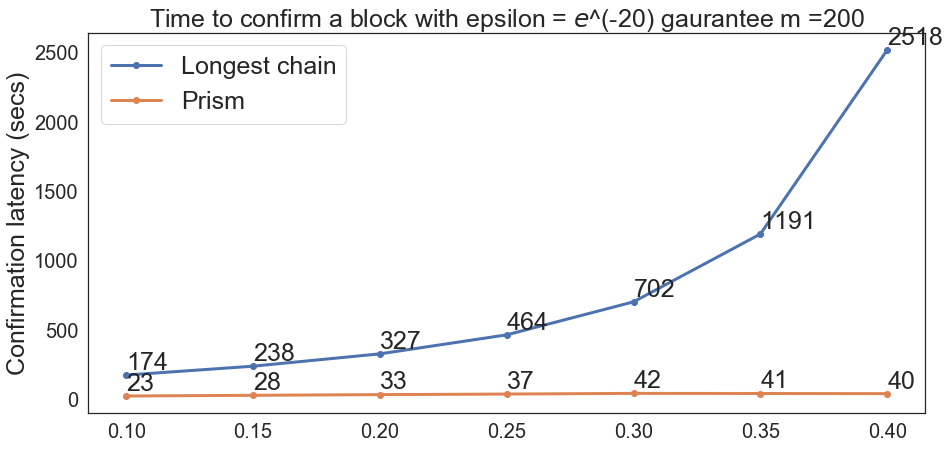

In [204]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

bitcoin_ans = bitcoin_ans.astype(int)
prism_ans = prism_ans.astype(int)
plt.plot(beta_calc, bitcoin_ans, '-o', lw=3, label="Longest chain")
plt.plot(beta_calc, prism_ans, '-o',lw=3, label="Prism")
for i in range(bitcoin_ans.shape[0]):
    ax.annotate(bitcoin_ans[i],xy=(beta_calc[i],bitcoin_ans[i]+40), size=25)
    ax.annotate(prism_ans[i],xy=(beta_calc[i],prism_ans[i]+40), size=25)
plt.ylabel("Confirmation latency (secs)", size=25)
# plt.xlabel("Beta", size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title("Time to confirm a block with epsilon = $e$^("+str(-log_epsilon)+") gaurantee m ="+str(m), size=25)
plt.legend(prop={'size': 25})
plt.show()


In [146]:
import sys
k = 10
for i in range(k):
    if (1>2):
        sys.exit()